In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
import gdown
from patsy import dmatrix

## Loading and cleaning

In [2]:
# Loading data from GDrive.

# Data with BDL merged,
file_id = "1SYvX9OHdWpuDWgYSWIfnZHJy2DL0p5lN"
url = f"https://drive.google.com/uc?id={file_id}"
file_extension = "downloaded_file.csv"
gdown.download(url, file_extension, quiet=False)
df = pd.read_csv(file_extension, sep=",")

Downloading...
From (original): https://drive.google.com/uc?id=1SYvX9OHdWpuDWgYSWIfnZHJy2DL0p5lN
From (redirected): https://drive.google.com/uc?id=1SYvX9OHdWpuDWgYSWIfnZHJy2DL0p5lN&confirm=t&uuid=9c525f6a-bf09-475c-80d7-5bf4297aa83d
To: C:\Users\KW\PycharmProjects\2024-mgr-sluzba-cywilna\Python\Code\downloaded_file.csv
100%|██████████| 254M/254M [00:08<00:00, 31.3MB/s] 


In [3]:
# Dropping data from 2017: too few records.
df = df[df['year'] > 2017]

# Dropping advertised_institution (too many nulls).
df.drop(['advertised_institution'], axis=1, inplace=True)

In [4]:
# Changing commas to dots in decimals.
df['unemployment'] = df['unemployment'].str.replace(",", ".", regex=False).astype(float)

In [5]:
# Changing "," to "." in numerical variables.
comma_cols_to_replace = {
    'mediana_wieku': 'bdl_age_median',
    'wydatki_powiat': 'bdl_district_expenses',
    'wynagrodzenia': 'bdl_average_salary'
}

# Replace commas with dots and convert to float.
for old_col, new_col in comma_cols_to_replace.items():
    try:
        df[new_col] = df[old_col].str.replace(',', '.', regex=False).astype(float)
    except AttributeError:
        df[new_col] = df[old_col]
        continue

df.drop(columns=comma_cols_to_replace.keys(), inplace=True)

In [6]:
# Other columns to rename.
col_names_to_replace = {
    'cena_mieszkan': 'bdl_avg_house_pricing',
    'saldo_migracji': 'bdl_migration_coefficient',
    'wsp_feminizacji': 'bdl_feminization_coefficient'
}

for old_col, new_col in col_names_to_replace.items():
    df[new_col] = df[old_col].astype(float)
    df.drop([old_col], axis=1, inplace=True)

In [7]:
df = df[df['work_time'] == 1]
df.drop(['work_time'], axis=1, inplace=True)

In [8]:
df = df[df['ad_views'].notnull()]

In [9]:
# We're not interested in these variables:
# - women_percentage, bdl_feminization_coefficient: low variability
# - bdl_district_expenses: too many nulls
# - applicants: that's what we're measuring, so adding that variable wouldn't make sense
df.drop(['women_percentage', 'bdl_feminization_coefficient', 'applicants', 'bdl_district_expenses'], axis=1, inplace=True)

## Imputation

In [10]:
# Imputing values for salary_for_position, since this variable has relatively low variance and is potentially of greater importance.
# However, imputing at institution-level won't solve the problem completely,
# since for some institutions, years or districts there was no data about salary at all.
# What is more, there was no salary data for średni szczebel zarządzania position category in the original data.
# Fortunately, that information was available here:
# https://dane.gov.pl/pl/dataset/1579/resource/56259,przecietne-wynagrodzenie-cakowite-wedug-grup-stanowisk-2023-r/table?page=1&per_page=20&q=&sort=
# For this reason, 6 imputations are needed (the sequence matters).

df_for_imputation_institution_level = df[df['salary_for_position'].notnull()]
df_for_imputation_district_level = df[df['salary_for_position'].notnull()]
df_for_imputation_voivodeship_level = df[df['salary_for_position'].notnull()]
df_for_imputation_year_level = df[df['salary_for_position'].notnull()]
df_for_imputation_category_level = df[df['salary_for_position'].notnull()]

df_for_imputation_institution_level = (
    df_for_imputation_institution_level
    .groupby(['district', 'voivodeship', 'institution', 'year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_institution'})
)

df_for_imputation_district_level = (
    df_for_imputation_district_level
    .groupby(['district', 'voivodeship', 'year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_district'})
)

df_for_imputation_voivodeship_level = (
    df_for_imputation_voivodeship_level
    .groupby(['voivodeship', 'year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_voivodeship'})
)

df_for_imputation_year_level = (
    df_for_imputation_year_level
    .groupby(['year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_year'})
)

df_for_imputation_category_level = (
    df_for_imputation_category_level
    .groupby(['position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_category'})
)


df = df.merge(df_for_imputation_institution_level, on=['district', 'voivodeship', 'institution', 'year', 'position_category'], how='left')
df = df.merge(df_for_imputation_district_level, on=['district', 'voivodeship', 'year', 'position_category'], how='left')
df = df.merge(df_for_imputation_voivodeship_level, on=['voivodeship', 'year', 'position_category'], how='left')
df = df.merge(df_for_imputation_year_level, on=['year', 'position_category'], how='left')
df = df.merge(df_for_imputation_category_level, on=['position_category'], how='left')

df['salary_for_position'] = df['salary_for_position'].fillna(df['median_institution'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_district'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_voivodeship'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_year'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_category'])

df = df.drop(columns=['median_institution', 'median_category', 'median_district', 'median_voivodeship', 'median_year'], axis=1)

# Assigning mean salaries for sredni szczebel zarzadzania manually (from the mentioned link):
mean_sredni_szczebel_2023 = 13160
mean_sredni_szczebel_2022 = 11322
mean_sredni_szczebel_2021 = 10579
mean_sredni_szczebel_2020 = 12633
mean_sredni_szczebel_2019 = 11693
mean_sredni_szczebel_2018 = 11088

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2023),
    'salary_for_position'
] = mean_sredni_szczebel_2023

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2022),
    'salary_for_position'
] = mean_sredni_szczebel_2022

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2021),
    'salary_for_position'
] = mean_sredni_szczebel_2021

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2020),
    'salary_for_position'
] = mean_sredni_szczebel_2020

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2019),
    'salary_for_position'
] = mean_sredni_szczebel_2019

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2018),
    'salary_for_position'
] = mean_sredni_szczebel_2018

In [11]:
# Fluctuation

df_for_imputation_institution_level = df[df['fluctuation'].notnull()]
df_for_imputation_district_level = df[df['fluctuation'].notnull()]
df_for_imputation_voivodeship_level = df[df['fluctuation'].notnull()]
df_for_imputation_year_level = df[df['fluctuation'].notnull()]

df_for_imputation_institution_level = (
    df_for_imputation_institution_level
    .groupby(['district', 'voivodeship', 'institution', 'year'])['fluctuation']
    .median()
    .reset_index()
    .rename(columns={'fluctuation': 'median_institution'})
)

df_for_imputation_district_level = (
    df_for_imputation_district_level
    .groupby(['district', 'voivodeship', 'year'])['fluctuation']
    .median()
    .reset_index()
    .rename(columns={'fluctuation': 'median_district'})
)

df_for_imputation_voivodeship_level = (
    df_for_imputation_voivodeship_level
    .groupby(['voivodeship', 'year'])['fluctuation']
    .median()
    .reset_index()
    .rename(columns={'fluctuation': 'median_voivodeship'})
)

df_for_imputation_year_level = (
    df_for_imputation_year_level
    .groupby(['year'])['fluctuation']
    .median()
    .reset_index()
    .rename(columns={'fluctuation': 'median_year'})
)


df = df.merge(df_for_imputation_institution_level, on=['district', 'voivodeship', 'institution', 'year'], how='left')
df = df.merge(df_for_imputation_district_level, on=['district', 'voivodeship', 'year'], how='left')
df = df.merge(df_for_imputation_voivodeship_level, on=['voivodeship', 'year'], how='left')
df = df.merge(df_for_imputation_year_level, on=['year'], how='left')

df['fluctuation'] = df['fluctuation'].fillna(df['median_institution'])
df['fluctuation'] = df['fluctuation'].fillna(df['median_district'])
df['fluctuation'] = df['fluctuation'].fillna(df['median_voivodeship'])
df['fluctuation'] = df['fluctuation'].fillna(df['median_year'])

df = df.drop(columns=['median_institution', 'median_district', 'median_voivodeship', 'median_year'], axis=1)

In [12]:
# Employment contract

df_for_imputation_institution_level = df[df['employment_contract'].notnull()]
df_for_imputation_district_level = df[df['employment_contract'].notnull()]
df_for_imputation_voivodeship_level = df[df['employment_contract'].notnull()]
df_for_imputation_year_level = df[df['employment_contract'].notnull()]

df_for_imputation_institution_level = (
    df_for_imputation_institution_level
    .groupby(['district', 'voivodeship', 'institution', 'year'])['employment_contract']
    .median()
    .reset_index()
    .rename(columns={'employment_contract': 'median_institution'})
)

df_for_imputation_district_level = (
    df_for_imputation_district_level
    .groupby(['district', 'voivodeship', 'year'])['employment_contract']
    .median()
    .reset_index()
    .rename(columns={'employment_contract': 'median_district'})
)

df_for_imputation_voivodeship_level = (
    df_for_imputation_voivodeship_level
    .groupby(['voivodeship', 'year'])['employment_contract']
    .median()
    .reset_index()
    .rename(columns={'employment_contract': 'median_voivodeship'})
)

df_for_imputation_year_level = (
    df_for_imputation_year_level
    .groupby(['year'])['employment_contract']
    .median()
    .reset_index()
    .rename(columns={'employment_contract': 'median_year'})
)


df = df.merge(df_for_imputation_institution_level, on=['district', 'voivodeship', 'institution', 'year'], how='left')
df = df.merge(df_for_imputation_district_level, on=['district', 'voivodeship', 'year'], how='left')
df = df.merge(df_for_imputation_voivodeship_level, on=['voivodeship', 'year'], how='left')
df = df.merge(df_for_imputation_year_level, on=['year'], how='left')

df['employment_contract'] = df['employment_contract'].fillna(df['median_institution'])
df['employment_contract'] = df['employment_contract'].fillna(df['median_district'])
df['employment_contract'] = df['employment_contract'].fillna(df['median_voivodeship'])
df['employment_contract'] = df['employment_contract'].fillna(df['median_year'])

df = df.drop(columns=['median_institution', 'median_district', 'median_voivodeship', 'median_year'], axis=1)

## Feature engineering

In [13]:
df['offer_salary'].replace("nie podano wynagrodzenia", np.nan, inplace=True)
df['offer_salary_mentioned'] = df['offer_salary'].notna().astype(int)
df.drop(['offer_salary'], axis=1, inplace=True)

C:\Users\KW\AppData\Local\Temp\ipykernel_12056\1148810047.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['offer_salary'].replace("nie podano wynagrodzenia", np.nan, inplace=True)


In [14]:
df['len_requirements'] = df['requirements'].str.count(r'\|-\|')
df['len_nice_to_have'] = df['nice_to_have'].str.count(r'\|-\|')
df['len_responsibilities'] = df['responsibilities'].str.count(r'\|-\|')

# null for nice-to-have means no nice-to-have.
df.loc[df['len_nice_to_have'].isnull(), 'len_nice_to_have'] = 0

df.drop(['requirements', 'nice_to_have', 'responsibilities'], axis=1, inplace=True)

## Analyses

In [15]:
# Number of ads and number of ads in time.
len(df)

96040

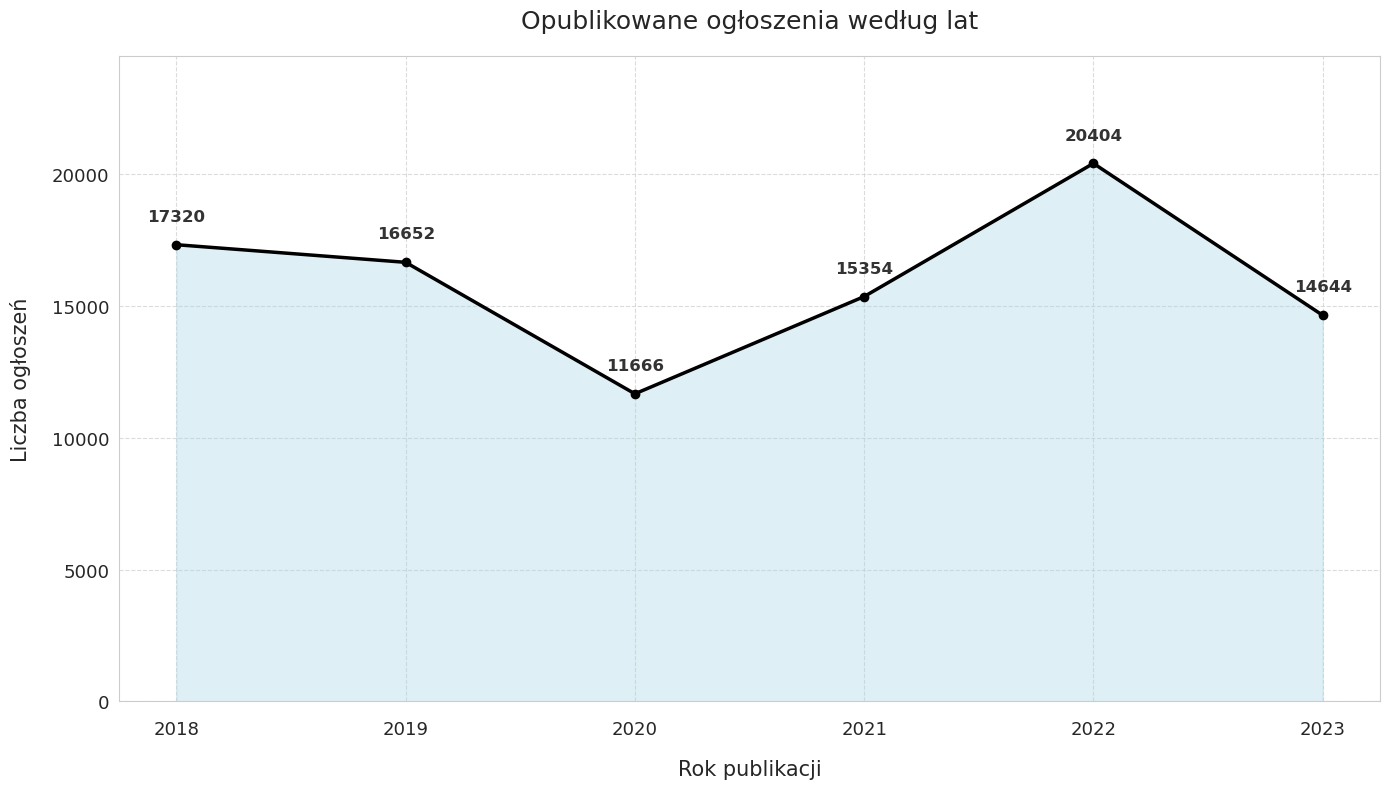

In [18]:
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'axes.titlesize': 18,  # Slightly larger title
    'axes.labelsize': 15,  # Slightly larger labels
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
})

plt.figure(figsize=(14, 8)) # Slightly larger figure

# Calculate counts per year and sort by year for time series
counts = df['year'].value_counts().sort_index()

# Plotting the line
ax = counts.plot(kind='line', marker='o', color='#000000', linewidth=2.5, zorder=3) # Increased linewidth, added zorder

# Adding the shaded area below the line
plt.fill_between(counts.index, counts.values, color='#ADD8E6', alpha=0.4) # Light blue shade with transparency

plt.xlabel('Rok publikacji', labelpad=15) # Increased labelpad
plt.ylabel('Liczba ogłoszeń', labelpad=15)
plt.title('Opublikowane ogłoszenia według lat', pad=20) # Increased title pad

ax.tick_params(axis='x', pad=10)

# Annotate each point with its value for better readability
for x, y in zip(counts.index, counts.values):
    ax.annotate(
        f'{int(y)}',
        (x, y),
        textcoords="offset points",
        xytext=(0, 15), # Increased offset for better visibility
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold', # Make annotations bold
        color='#333333' # Darker color for annotations
    )

ax.set_ylim(0, counts.max() * 1.20) # Adjust y-limit further for annotations
plt.grid(True, linestyle='--', alpha=0.7, zorder=0) # Slightly more opaque grid
plt.tight_layout()

# export
plt.savefig("year_time_series_beautiful.png", format="png", bbox_inches="tight")
plt.show()

##### Correlation

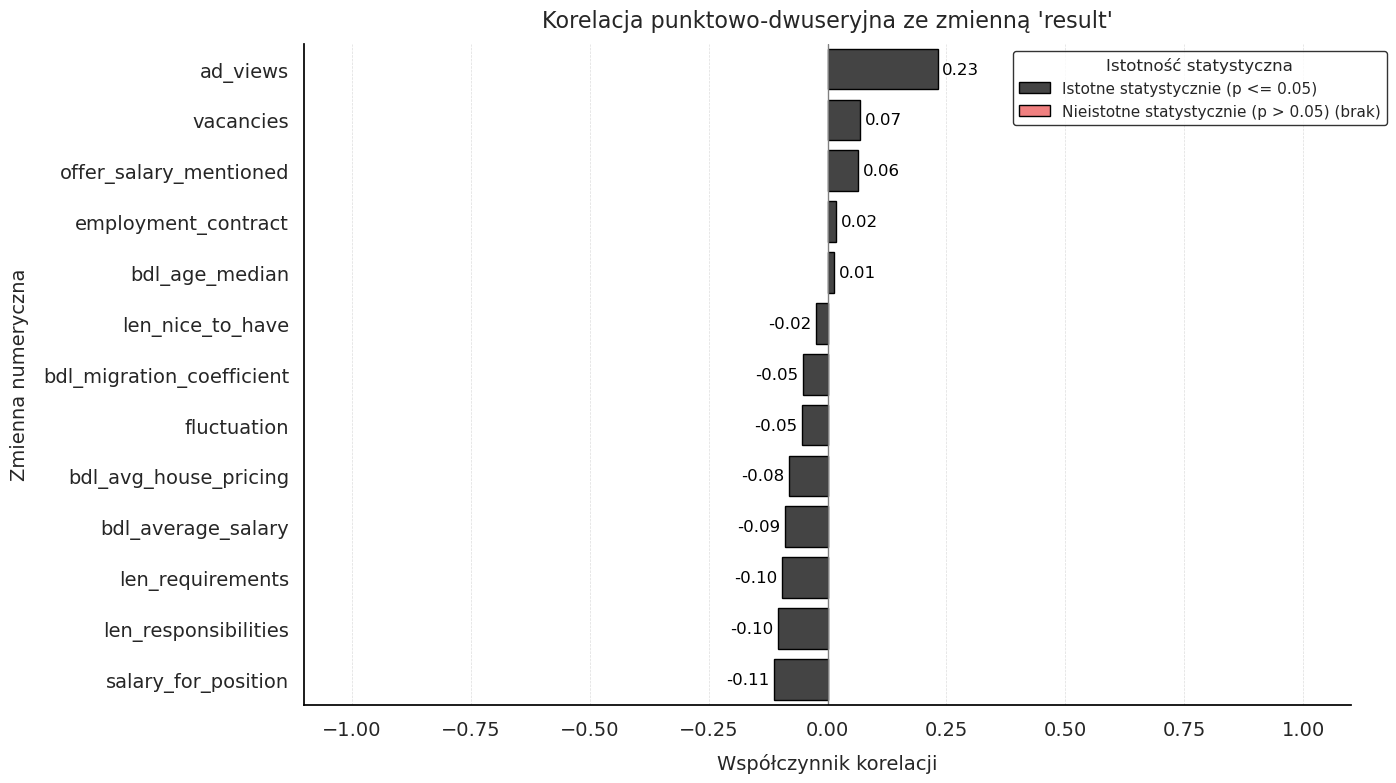


Szczegółowe wyniki korelacji:
                           correlation  is_statistically_significant
ad_views                      0.231427                             1
vacancies                     0.068625                             1
offer_salary_mentioned        0.064624                             1
employment_contract           0.017761                             1
bdl_age_median                0.013534                             1
len_nice_to_have             -0.023733                             1
bdl_migration_coefficient    -0.050769                             1
fluctuation                  -0.053511                             1
bdl_avg_house_pricing        -0.081331                             1
bdl_average_salary           -0.088522                             1
len_requirements             -0.096059                             1
len_responsibilities         -0.104691                             1
salary_for_position          -0.113068                             1


In [15]:
from scipy import stats

numerical_columns = [
    'ad_views',
    'offer_salary_mentioned',
    'salary_for_position',
    'fluctuation',
    'employment_contract',
    'bdl_avg_house_pricing',
    'bdl_age_median',
    'bdl_migration_coefficient',
    'bdl_average_salary',
    'vacancies',
    'len_requirements',
    'len_nice_to_have',
    'len_responsibilities'
]

correlation_results = {}
for col in numerical_columns:
    x = df['result']
    y = df[col]
    valid = x.notna() & y.notna()
    if sum(valid) > 1:
        r, p = stats.pointbiserialr(x[valid], y[valid])
        correlation_results[col] = {
            'correlation': r,
            'is_statistically_significant': int(p <= 0.05)
        }
    else:
        print(f"Brak wystarczających danych do obliczenia korelacji dla kolumny: {col}")

correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index')
correlation_df = correlation_df.sort_values(by=['is_statistically_significant', 'correlation'], ascending=[False, False])

# --- Konfiguracja wykresu w stylu IBCS ---

sns.set(style='whitegrid')
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'grid.color': '#DDDDDD',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'axes.edgecolor': 'black'
})

plt.figure(figsize=(14, max(8, len(numerical_columns) * 0.6)))

bar_color_significant = '#444444' # Ciemny szary

ax = sns.barplot(
    x='correlation',
    y=correlation_df.index,
    data=correlation_df,
    color=bar_color_significant,
    edgecolor='black',
    ax=plt.gca()
)

ax.set_ylabel("Zmienna numeryczna", labelpad=10)
ax.set_xlabel("Współczynnik korelacji", labelpad=10)
ax.tick_params(axis='y', pad=5)
ax.tick_params(axis='x', pad=5)

for p in ax.patches:
    width = p.get_width() # Pobieramy szerokość słupka (wartość korelacji)
    # Poprawka tutaj: formatujemy 'width' bezpośrednio, a nie 'width - 0.01'
    if width >= 0:
        ax.annotate(f'{width:.2f}',
                    (width + 0.01, p.get_y() + p.get_height() / 2.),
                    ha='left', va='center', fontsize=12, color='black')
    else:
        # Ta linia została poprawiona
        ax.annotate(f'{width:.2f}',
                    (width - 0.01, p.get_y() + p.get_height() / 2.),
                    ha='right', va='center', fontsize=12, color='black')

ax.set_xlim(-1.1, 1.1)
ax.axvline(0, color='gray', linestyle='-', linewidth=1)
ax.set_title("Korelacja punktowo-dwuseryjna ze zmienną 'result'", pad=12)
sns.despine(left=False, bottom=False)

# Ręczne tworzenie legendy
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor=bar_color_significant, edgecolor='black', label='Istotne statystycznie (p <= 0.05)'),
    Patch(facecolor='lightcoral', edgecolor='black', label='Nieistotne statystycznie (p > 0.05) (brak)')
]

ax.legend(handles=legend_elements,
          title='Istotność statystyczna',
          frameon=True,
          edgecolor='black',
          bbox_to_anchor=(0.67, 1),
          loc='upper left')

plt.tight_layout()

plt.savefig(f"point_biserial_correlation.png", format="png", bbox_inches="tight")
plt.show()

print("\nSzczegółowe wyniki korelacji:")
print(correlation_df)

In [16]:
df[numerical_columns].describe()

ad_views  offer_salary_mentioned  salary_for_position  \
count  96040.000000            96040.000000         96040.000000   
mean    2067.338047                0.271731          6041.427301   
std      843.645392                0.444854          1650.320724   
min      124.000000                0.000000           990.833333   
25%     1337.000000                0.000000          4840.697276   
50%     2146.000000                0.000000          5833.339921   
75%     2622.000000                1.000000          6831.692744   
max    11725.000000                1.000000         22911.326995   

        fluctuation  employment_contract  bdl_avg_house_pricing  \
count  96040.000000         96040.000000           96040.000000   
mean       0.099069           577.759261            7123.717628   
std        0.087798           657.441935            2939.196058   
min        0.000000             0.050000               0.000000   
25%        0.066502            18.300000            4743.000000   
50%        0.081996           284.850000            6656.000000   
75%        0.110191           820.250000            9129.000000   
max        3.846154          3271.880000           15717.000000   

       bdl_age_median  bdl_migration_coefficient  bdl_average_salary  \
count    96040.000000               96040.000000        96040.000000   
mean        41.950353                2811.867024         6412.095721   
std          1.780767                4011.859714         1509.840859   
min         34.600000               -1065.000000         3183.340000   
25%         40.700000                -171.000000         5252.170000   
50%         41.500000                 189.000000         6432.780000   
75%         43.300000                6224.000000         7391.950000   
max         48.900000               11727.000000        12804.030000   

          vacancies  len_requirements  len_nice_to_have  len_responsibilities  
count  96040.000000      96040.000000      96040.000000          96040.000000  
mean       1.118419          7.732663          3.258871              5.366524  
std        0.459370          3.085298          2.496036              2.230622  
min        1.000000          2.000000          0.000000              0.000000  
25%        1.000000          6.000000          1.000000              4.000000  
50%        1.000000          7.000000          3.000000              5.000000  
75%        1.000000          9.000000          5.000000              7.000000  
max        5.000000         31.000000         23.000000             32.000000

##### Bar charts

In [17]:
def plot_ibcs_bar_chart(df: pd.DataFrame, group_col: str):
    # Przygotowanie danych
    group_means = df.groupby(group_col)['result'].mean().reset_index()

    # Upewniamy się, że group_col ma typ string
    group_means[group_col] = group_means[group_col].astype(str)

    group_means.sort_values(by='result', ascending=False, inplace=True)
    n_categories = group_means.shape[0]

    # Paleta kolorów IBCS
    ibcs_palette = ['#000000', '#444444', '#777777', '#AAAAAA', '#DDDDDD']
    colors = ibcs_palette * ((n_categories // len(ibcs_palette)) + 1)

    # Tworzenie wykresu poziomego
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        y=group_col,
        x='result',
        data=group_means,
        palette=colors[:n_categories],
        edgecolor='black'
    )

    # Oznaczenia
    ax.set_ylabel(group_col, labelpad=10)
    ax.set_xlabel("Średni odsetek udanych obsadzeń", labelpad=10)
    ax.tick_params(axis='y', pad=5)

    # Dodanie etykiet wartości na końcach słupków
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(f'{width:.2f}',
                    (width + 0.01, p.get_y() + p.get_height() / 2.),
                    ha='left', va='center', fontsize=14)

    ax.set_xlim(0, group_means['result'].max() * 1.10)
    ax.set_title(f"Średni wynik względem {group_col}", pad=12)
    
    sns.set(style='whitegrid')
    plt.rcParams.update({
        'font.family': 'DejaVu Sans',
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
    })
    sns.despine()
    plt.tight_layout()
    # Export
    plt.savefig(f"mean_result_by_{group_col}.png", format="png", bbox_inches="tight")
    plt.show()

C:\Users\KW\AppData\Local\Temp\ipykernel_10292\1203319668.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


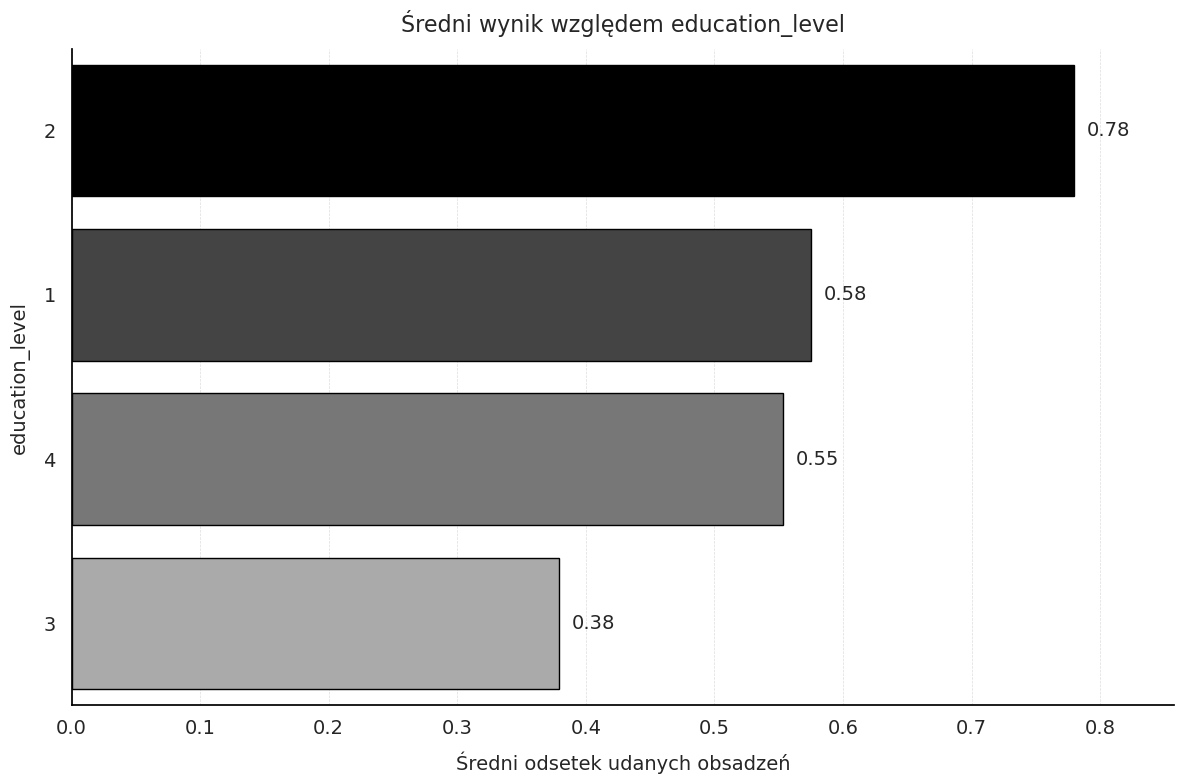

C:\Users\KW\AppData\Local\Temp\ipykernel_10292\1203319668.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


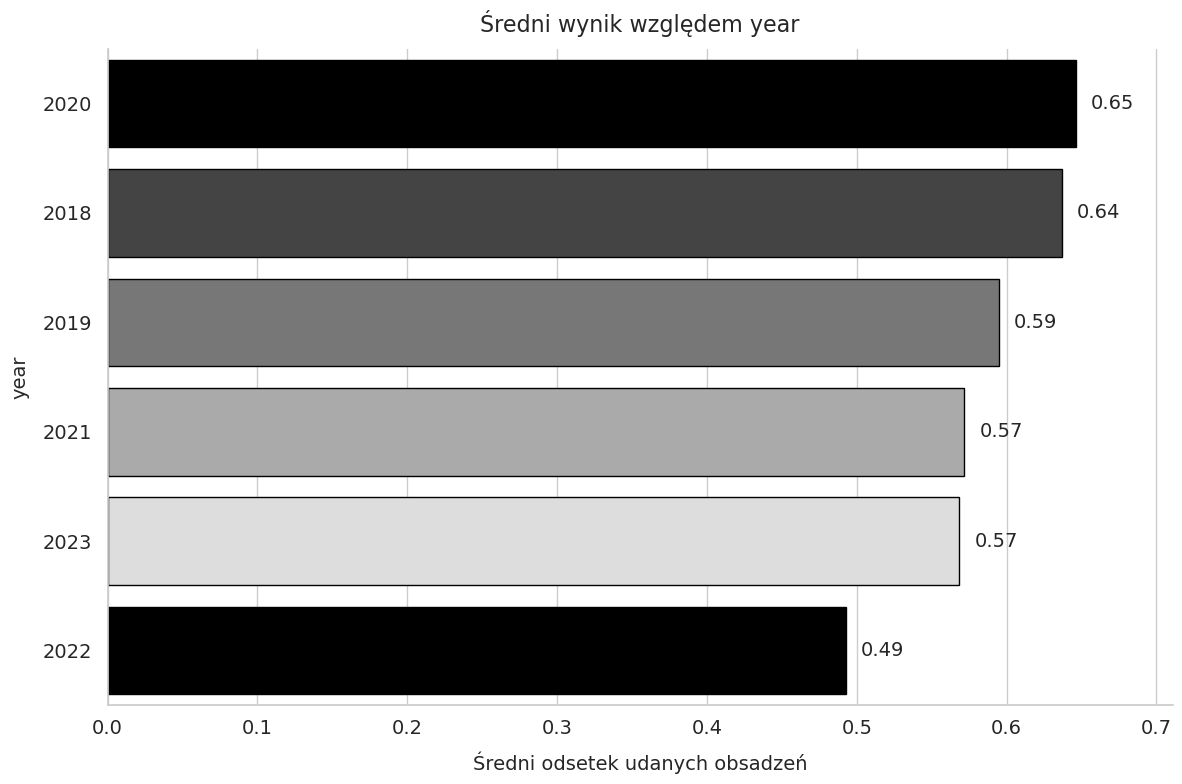

C:\Users\KW\AppData\Local\Temp\ipykernel_10292\1203319668.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


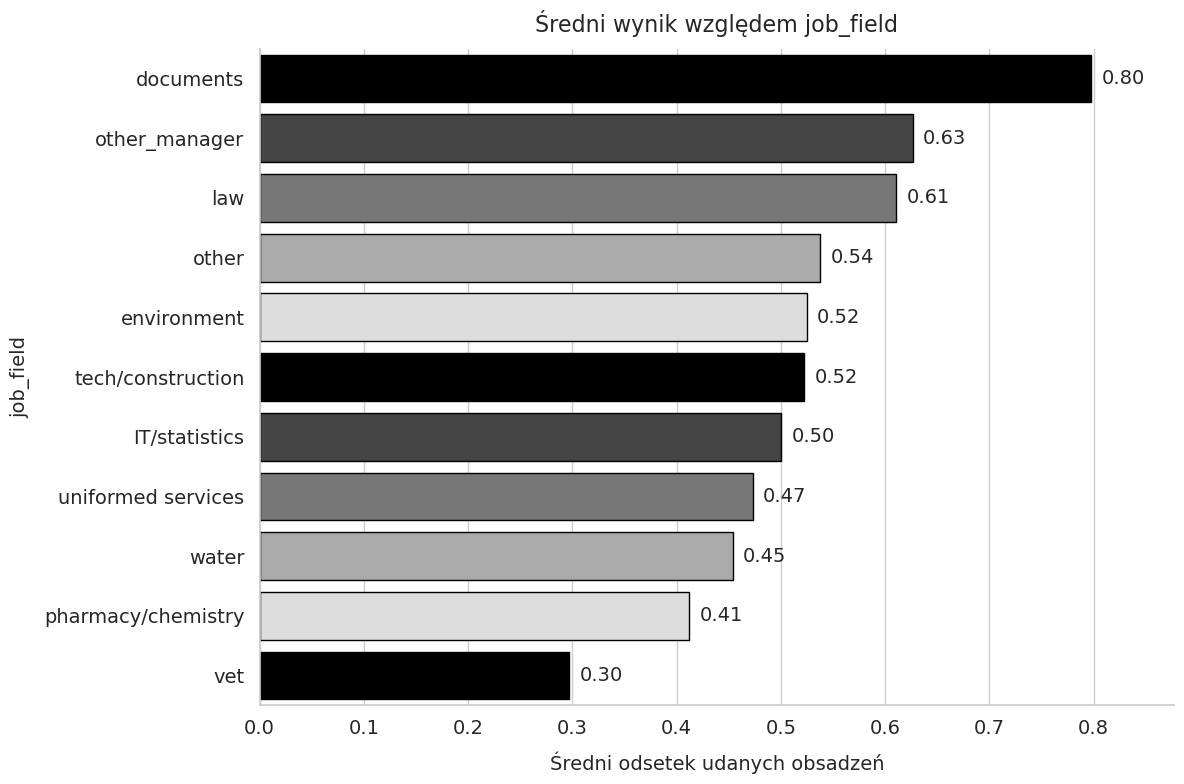

C:\Users\KW\AppData\Local\Temp\ipykernel_10292\1203319668.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


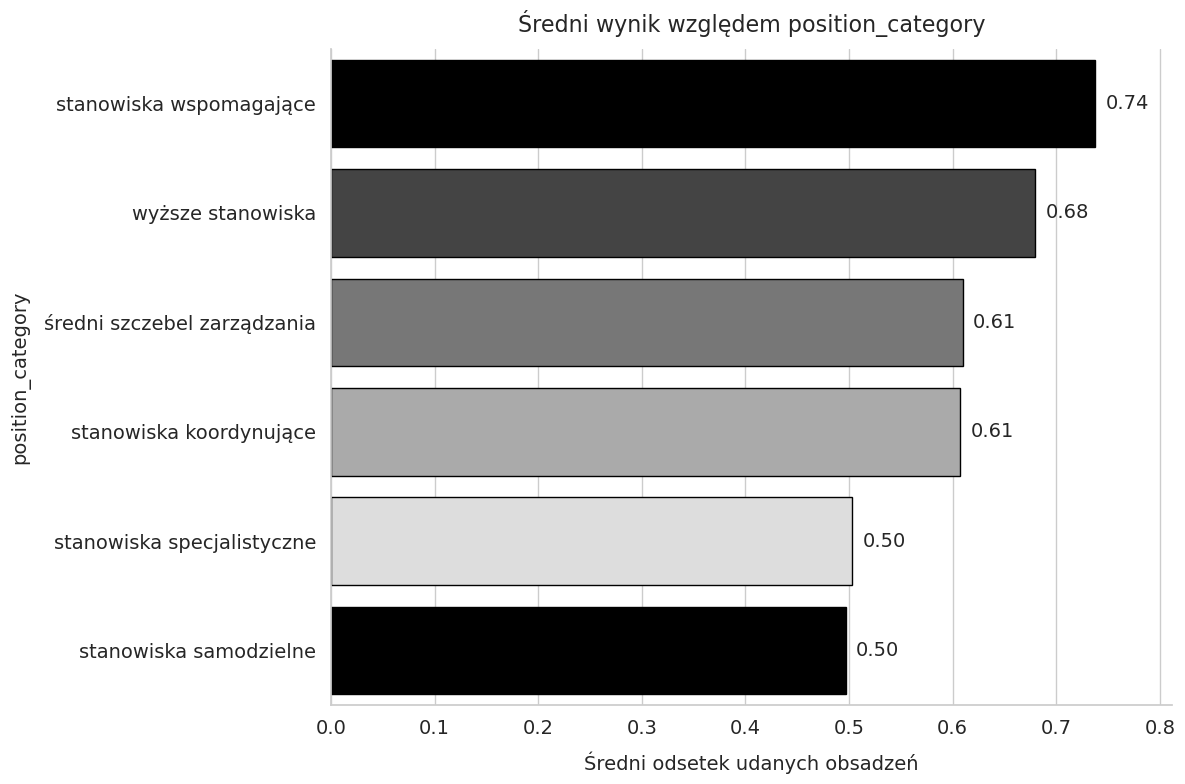

In [18]:
plot_bar_columns = [
    'education_level',
    'year',
    'job_field',
    'position_category'
]

for column in plot_bar_columns:
    plot_ibcs_bar_chart(df, column)

##### Time series

In [25]:
# Dropping cols unnecessary for statistical analyses.
string_cols_for_temporary_dropping = [
    'ad_id',
    'institution_address',
    'workplace',
    'department',
    'date_announced',
    'institution_address',
    'workplace',
    'department',
    'city',
    'position',
    'vacancies'
]

df_for_charts = df.drop(string_cols_for_temporary_dropping, axis=1)
df_for_charts["voivodeship_district"] = df_for_charts['voivodeship'].astype(str) + df_for_charts['district'].astype(str)

In [26]:
# Time series for the chosen set of variables.
df_for_charts_time_series = df_for_charts[['ad_views', 'result', 'offer_salary_mentioned', 'fluctuation', 'year']]
# Unifying scale.
import numpy as np
df_for_charts_time_series['ad_views_/_10000'] = df_for_charts_time_series['ad_views'] / 10000
df_for_charts_time_series.drop(['ad_views'], axis=1, inplace=True)

C:\Users\KW\AppData\Local\Temp\ipykernel_10292\373324191.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_charts_time_series['ad_views_/_10000'] = df_for_charts_time_series['ad_views'] / 10000
C:\Users\KW\AppData\Local\Temp\ipykernel_10292\373324191.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_charts_time_series.drop(['ad_views'], axis=1, inplace=True)


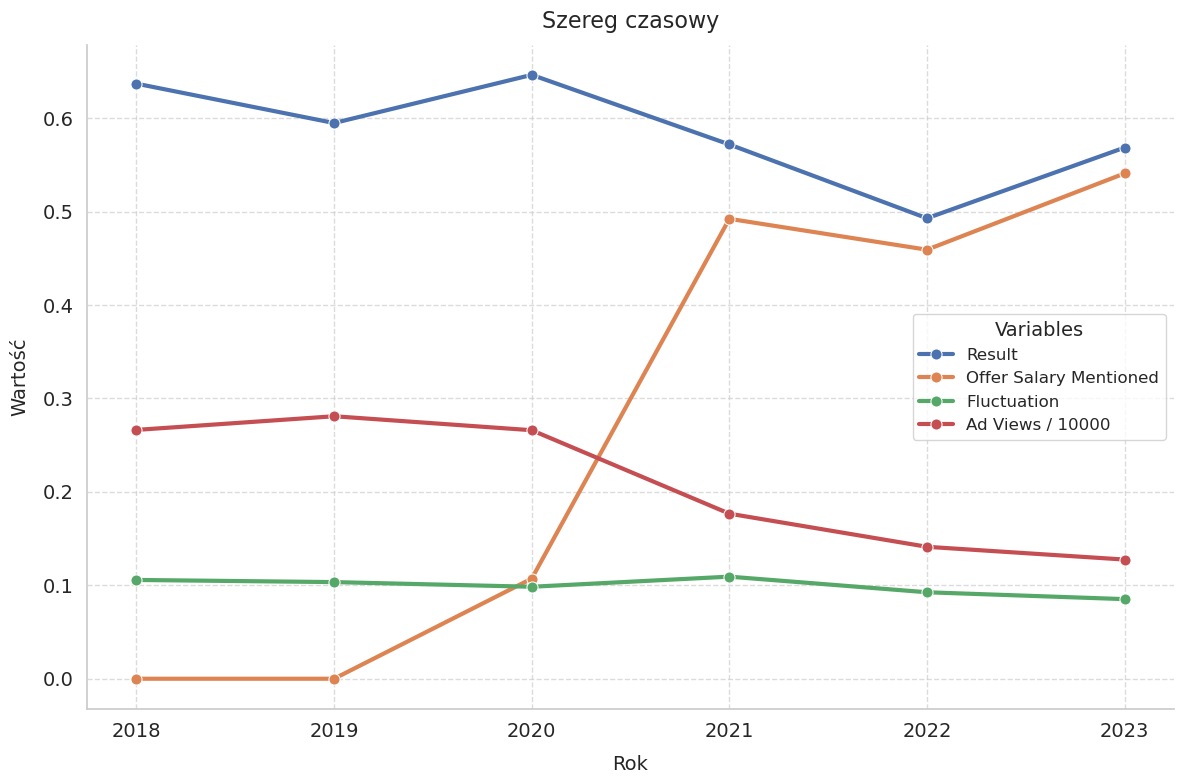

In [27]:
def plot_individual_time_series_combined(dataframe):    
    # Agregacja
    df_grouped = dataframe.groupby('year').mean(numeric_only=True)
    columns_to_plot = [col for col in df_grouped.columns]

    sns.set(style='whitegrid')
    plt.rcParams.update({
        'font.family': 'DejaVu Sans',
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
    })

    plt.figure(figsize=(12, 8))
    ax = plt.gca()

    for column in columns_to_plot:
        sns.lineplot(
            x=df_grouped.index,
            y=df_grouped[column],
            marker='o',
            markersize=8,
            linewidth=3,
            label=column.replace('_', ' ').title(),
            ax=ax
        )

    ax.set_title("Szereg czasowy", pad=12)
    ax.set_xlabel("Rok", labelpad=10)
    ax.set_ylabel("Wartość", labelpad=10)
    ax.tick_params(axis='both', labelsize=14)
    ax.grid(True, linestyle='--', linewidth=1, alpha=0.7)
    ax.legend(title='Variables', fontsize=12, title_fontsize=14, loc='best')

    sns.despine()
    plt.tight_layout()
    plt.savefig("combined_time_series.png", format="png", bbox_inches="tight")
    plt.show()

plot_individual_time_series_combined(df_for_charts_time_series)

##### Variability charts

In [21]:
# def plot_variability(dataframe):
#     exclude_columns = ['work_time', 'year', 'district', 'voivodeship', 'institution']
#     df_grouped = dataframe.groupby('district').mean(numeric_only=True)
#     columns_to_plot = [col for col in df_grouped.columns if col not in exclude_columns]
# 
#     sns.set(style="whitegrid", context="talk", palette="deep")
# 
#     for column in columns_to_plot:
#         plt.figure(figsize=(12, 6))
#         sns.lineplot(x=df_grouped.index, y=df_grouped[column], marker='o', linewidth=2.5)
#         plt.title(f"{column.replace('_', ' ').title()} District Variability", fontsize=16, weight='bold')
#         plt.xlabel("District", fontsize=13)
#         plt.ylabel(column.replace('_', ' ').title(), fontsize=13)
#         plt.xticks(rotation=45, fontsize=11)
#         plt.yticks(fontsize=11)
#         plt.grid(visible=True, linestyle='--', alpha=0.7)
#         plt.tight_layout()
#         plt.show()
# 
# plot_variability(df_for_charts)

##### Spaghetti plots

In [22]:
df_for_charts_district_agg = df_for_charts.groupby(by=['voivodeship_district', 'year'])['result'].mean()
df_for_charts_institution_agg = df_for_charts.groupby(by=['institution', 'year'])['result'].mean()

In [23]:
def plot_spaghetti_chart(df_grouped, group_cols, file_title):
    df = df_grouped.reset_index()
    
    groups = df.groupby(group_cols)

    plt.figure(figsize=(10, 6))
    for group_vals, group_data in groups:
        label = '-'.join(map(str, group_vals)) if isinstance(group_vals, tuple) else str(group_vals)
        plt.plot(group_data['year'], group_data['result'], label=label)

    plt.xlabel('Year')
    plt.ylabel('Result')
    plt.title('Spaghetti Chart')
    plt.tight_layout()
    plt.savefig(file_title, format="png", bbox_inches="tight")
    plt.show()

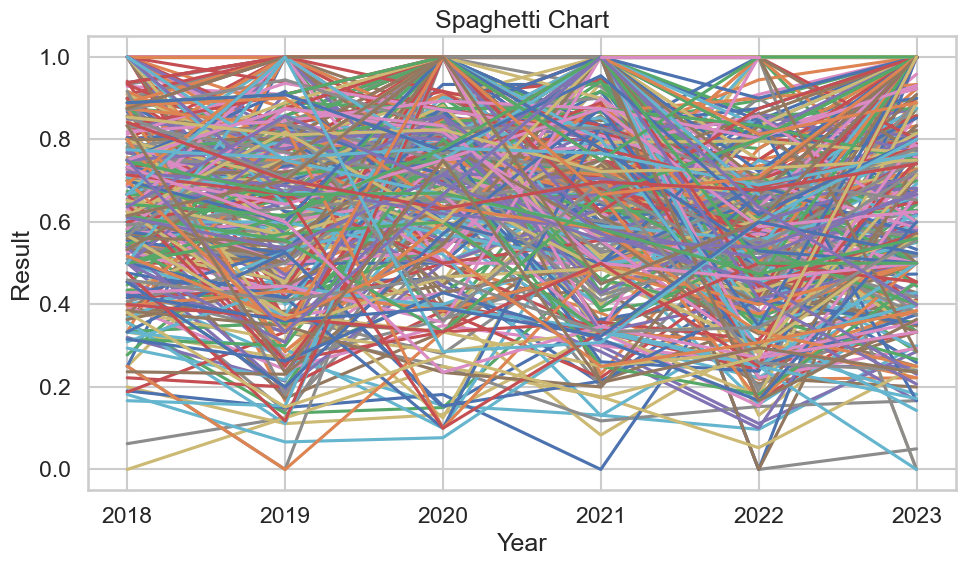

In [24]:
plot_spaghetti_chart(df_for_charts_district_agg, ['voivodeship_district'], "spaghetti_district.png")

In [25]:
plot_spaghetti_chart(df_for_charts_institution_agg, ['institution'], "spaghetti_institution.png")

## Feature importance

In [26]:
# bdl_avg_salary, salary_for_position, and bdl_housing are correlated with each other.
df['relative_salary'] = df['salary_for_position'] / df['bdl_average_salary']
df.drop(['salary_for_position', 'bdl_average_salary', 'bdl_avg_house_pricing'], axis=1, inplace=True)

##### Preparing data for logistic regression

In [27]:
# Dealing with categorical columns with the use of USM method
# (an alternative to 1hot encoding in which each category is represented by coefficients that sum to zero).

education_matrix = dmatrix('C(education_level, Sum)', df, return_type='dataframe').iloc[:, 1:]
df = pd.concat([df.drop('education_level', axis=1), education_matrix], axis=1)

position_matrix = dmatrix('C(position_category, Sum)', df, return_type='dataframe').iloc[:, 1:]
job_field_matrix = dmatrix('C(job_field, Sum)', df, return_type='dataframe').iloc[:, 1:]

df = pd.concat([df.drop(['position_category', 'job_field'], axis=1), position_matrix, job_field_matrix], axis=1)

In [28]:
df_model = df.drop(string_cols_for_temporary_dropping, axis=1)
df_model['voivodeship_district'] = df_model['voivodeship'].astype(str) + df_model['district'].astype(str)
df_model.drop(['voivodeship', 'district'], axis=1, inplace=True)

In [29]:
# Excluding institutions that posted less than 10 job ads

# Calculate the frequency of each institution.
institution_counts = df_model['institution'].value_counts()

# Identify institutions to exclude.
institutions_to_exclude = institution_counts[institution_counts < 10].index

# Filter df_model to keep only institutions that appear 10 or more times.
df_model = df_model[~df_model['institution'].isin(institutions_to_exclude)]

In [30]:
# Excluding institutions that are 0- or 1-inflated.
institutions_inflated = []
for institution, group in df_model.groupby('institution'):
    unique_results = group['result'].unique()
    if len(unique_results) == 1 and (unique_results[0] == 0 or unique_results[0] == 1):
        institutions_inflated.append(institution)

df_model = df_model[~df_model['institution'].isin(institutions_inflated)]

In [31]:
# Making year a categorical col
df_model['year_2022'] = (df_model['year'] == 2022).astype(int)
df_model['year_before_2020'] = (df_model['year'] <= 2020).astype(int)
df_model.drop(['year'], axis=1, inplace=True)

In [32]:
# # Log transformations before performing standardization.
# variables_to_plot = ['ad_views', 'relative_salary', 'fluctuation', 'employment_contract', 'foreign_capital', 'unemployment', 'bdl_age_median', 'bdl_migration_coefficient']
# 
# for column in variables_to_plot:
#     plt.figure(figsize=(10, 6))
#     sns.histplot(df_model[column], kde=True)
#     plt.title(f'Distribution of {column}')
#     plt.xlabel(column)
#     plt.ylabel('Frequency')
#     plt.tight_layout()
#     plt.show()

In [33]:
variables_to_log_transform = ['ad_views', 'relative_salary', 'foreign_capital', 'fluctuation', 'employment_contract']
for col in variables_to_log_transform:
    df_model[col] = np.log1p(df_model[col])

In [34]:
# I'm using cuberoot transformation for the migration coefficient, since it contains negative values.
df_model['bdl_migration_coefficient'] = np.cbrt(df_model['bdl_migration_coefficient'])

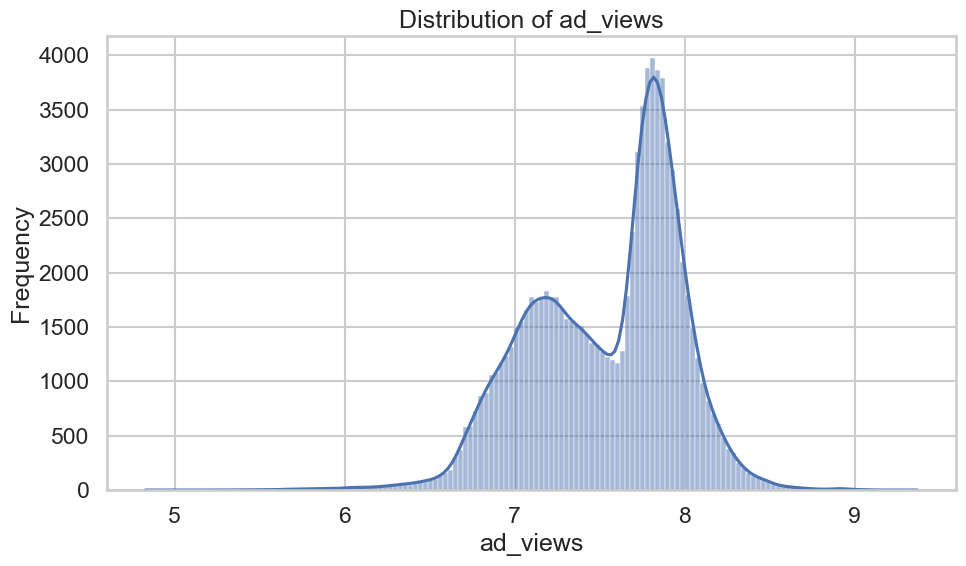

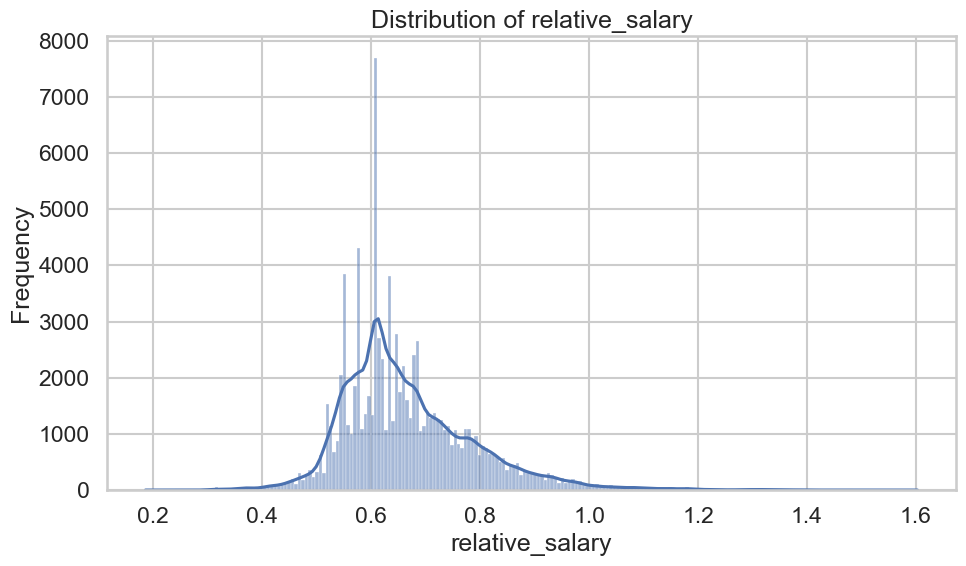

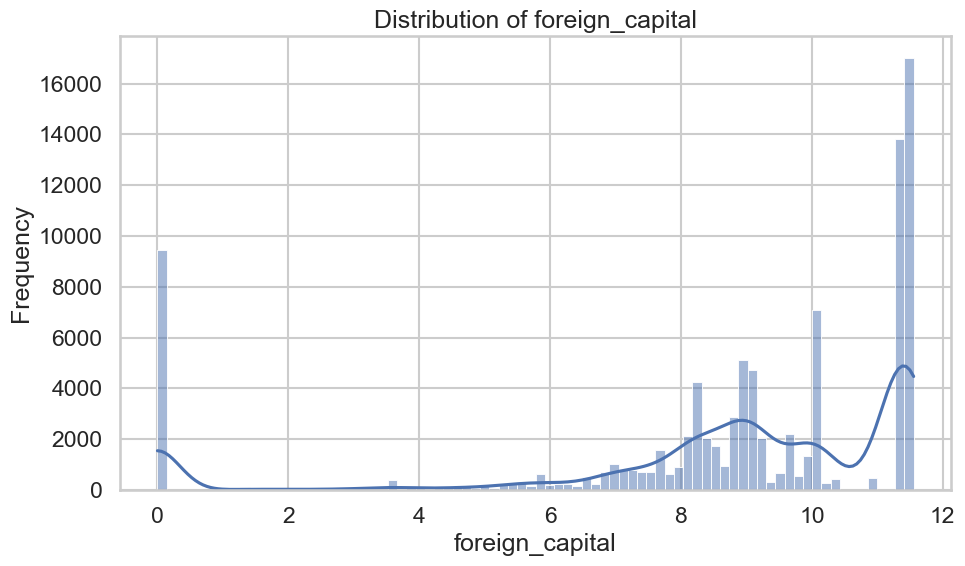

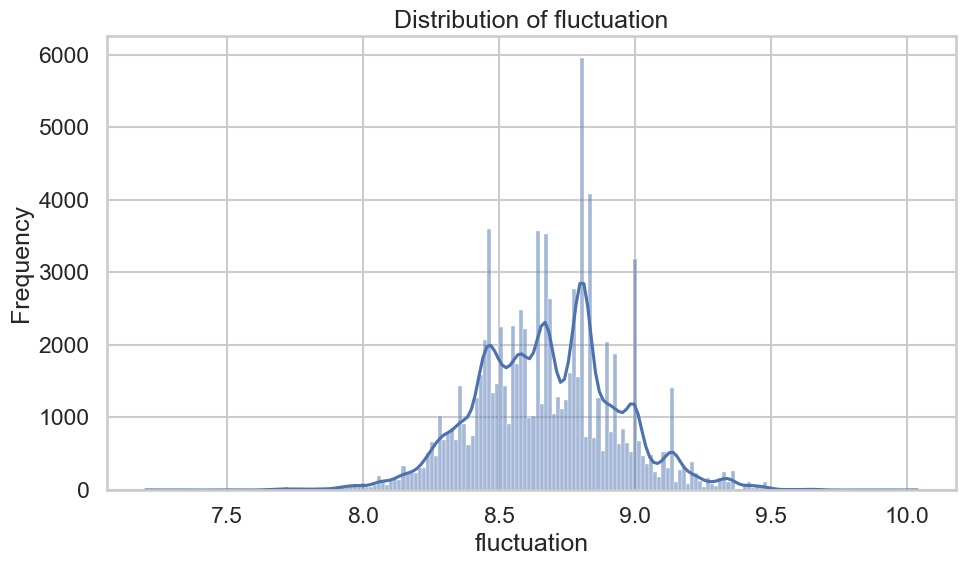

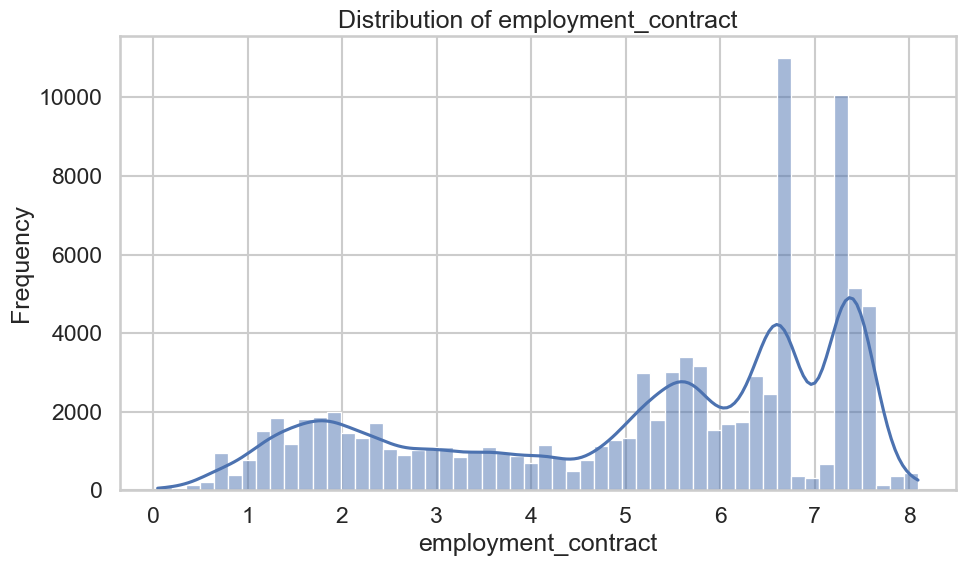

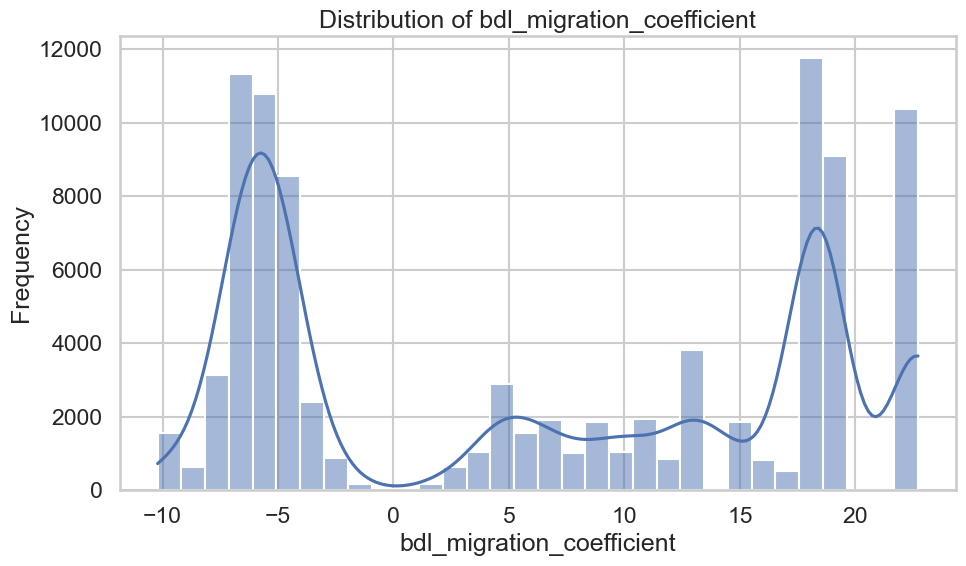

In [35]:
# Plotting distributions after transformation.
transformed_variables_to_plot = ['ad_views', 'relative_salary', 'foreign_capital', 'fluctuation', 'employment_contract', 'bdl_migration_coefficient']

for column in transformed_variables_to_plot:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_model[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [36]:
from sklearn.model_selection import train_test_split

# Stratified train-test split (90% train, 10% test) based on an institution.
df_train, df_test = train_test_split(
    df_model,
    test_size=0.1,
    stratify=df_model['institution'],
    random_state=42
)

In [37]:
# Standarization.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Excluding categorical cols.
position_category_cols = df_train.filter(regex=r'^position_category').columns.tolist()
job_field_cols = df_train.filter(regex=r'^job_field').columns.tolist()
cols_to_exclude_from_standarization = ['result', 'institution', 'voivodeship_district', 'year_2022', 'year_before_2020'] + position_category_cols + job_field_cols

X_train_features = df_train.drop(cols_to_exclude_from_standarization, axis=1)
scaler.fit(X_train_features)
X_train_scaled = scaler.transform(X_train_features)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_features.columns, index=X_train_features.index)
X_train_scaled_df = pd.concat([X_train_scaled_df, df_train[cols_to_exclude_from_standarization]], axis=1)

In [38]:
# Standardizing the test set (with the scaler fitted on the training data).
X_test_features = df_test.drop(cols_to_exclude_from_standarization, axis=1)
X_test_scaled = scaler.transform(X_test_features)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_features.columns, index=X_test_features.index)
X_test_scaled_df = pd.concat([X_test_scaled_df, df_test[cols_to_exclude_from_standarization]], axis=1)

In [39]:
institution_matrix_train = dmatrix('C(institution, Sum)', df_model, return_type='dataframe').iloc[:, 1:]
district_matrix_train = dmatrix('C(voivodeship_district, Sum)', df_model, return_type='dataframe').iloc[:, 1:]

df_model_institutions = pd.concat([df_model.drop(['institution', 'voivodeship_district'], axis=1), institution_matrix_train], axis=1)
df_model_districts = pd.concat([df_model.drop(['institution', 'voivodeship_district'], axis=1), district_matrix_train], axis=1)

df_model = X_train_scaled_df
df_model_institutions = df_model_institutions.loc[df_model.index]
df_model_districts = df_model_districts.loc[df_model.index]

df_test = X_test_scaled_df
institution_matrix_test = dmatrix('C(institution, Sum)', df_test, return_type='dataframe').iloc[:, 1:]
district_matrix_test = dmatrix('C(voivodeship_district, Sum)', df_test, return_type='dataframe').iloc[:, 1:]

df_test_institutions = pd.concat([df_test.drop(['institution', 'voivodeship_district'], axis=1), institution_matrix_test], axis=1)
df_test_districts = pd.concat([df_test.drop(['institution', 'voivodeship_district'], axis=1), district_matrix_test], axis=1)

df_model.drop(['institution', 'voivodeship_district'], axis=1, inplace=True)
df_test.drop(['institution', 'voivodeship_district'], axis=1, inplace=True)

##### Applying logistic regression

In [40]:
# Function grouping together 1hot encoded categorical variables for dalex's Explainer.
def create_variable_groups(encoded_df, original_categorical_cols):
    dalex_variable_groups = {}

    for cat_col in original_categorical_cols:
        # Find all dummy columns for this categorical variable
        dummy_cols = [col for col in encoded_df.columns
                     if col.startswith(f'C({cat_col}, Sum)[S.')]

        if dummy_cols:
            dalex_variable_groups[cat_col] = dummy_cols

    return dalex_variable_groups

In [41]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import dalex as dx
import warnings

def log_regression(train_set, test_set, penalty, solver, cv, original_categorical_cols:list):
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)

    np.random.seed(42)

    X_train = train_set.drop('result', axis=1)
    y_train = train_set['result']
    X_test = test_set.drop('result', axis=1)
    y_test = test_set['result']

    model = LogisticRegression(penalty=penalty, solver=solver, random_state=42, max_iter=5000)

    param_grid = {
        'C': np.logspace(-4, 2, 7)
    }

    print("\nGridSearchCV")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    optimal_C = grid_search.best_params_['C']
    best_logistic_model = grid_search.best_estimator_

    print(f"\nOptimal C found: {optimal_C}")
    print(f"Best cross-validation ROC AUC: {grid_search.best_score_:.4f}")

    print("\nInitializing DALEX Explainer")

    explainer = dx.Explainer(
        model = best_logistic_model,
        data = X_train,
        y = y_train,
        verbose=False,
        label=f"Logistic Regression (Optimal C={optimal_C:.4f}, Penalty={penalty})"
    )

    print("Calculating DALEX Feature Importance (Combined)")

    # 1. Get feature importance for all individual features
    fi_all_features_result = explainer.model_parts().result.copy()

    # Filter out the 'baseline' row from the individual features result (I only want to plot actual features).
    fi_all_features_result = fi_all_features_result[fi_all_features_result['variable'] != '_baseline_'].copy()

    # 2. Identify the dummy columns that need to be grouped
    dalex_variable_groups = create_variable_groups(X_train, original_categorical_cols)

    # Prepare a list of dummy columns that are part of the original categorical columns
    dummy_cols_to_remove = []
    for group_name, dummy_cols in dalex_variable_groups.items():
        dummy_cols_to_remove.extend(dummy_cols)

    # 3. Calculate importance for the grouped categorical features
    fi_grouped_result = pd.DataFrame()
    if dalex_variable_groups:
        fi_grouped_explainer_result = explainer.model_parts(variable_groups=dalex_variable_groups).result.copy()
        # Filter out any potential 'baseline' generated specifically by the grouped calculation
        fi_grouped_result = fi_grouped_explainer_result[fi_grouped_explainer_result['variable'] != '_baseline_'].copy()

    # 4. Create the final unified DataFrame for plotting
    final_fi_df = pd.DataFrame(columns=['variable', 'dropout_loss', 'mean_dropout_loss', 'permutation', 'original_dropout_loss'])

    # Add features from the filtered individual results
    for index, row in fi_all_features_result.iterrows():
        if row['variable'] not in dummy_cols_to_remove:
            final_fi_df = pd.concat([final_fi_df, pd.DataFrame([row])], ignore_index=True)

    # Add the grouped categorical features
    if not fi_grouped_result.empty:
        # Use a consistent name, adding the ' (Grouped)' prefix.
        fi_grouped_result['variable'] = fi_grouped_result['variable'].apply(lambda x: f'{x} (Grouped)')
        final_fi_df = pd.concat([final_fi_df, fi_grouped_result], ignore_index=True)

    # Filtering out the baseline from the chart.
    final_fi_df = final_fi_df[final_fi_df['variable'] != '_full_model_ (Grouped)'].copy()

    final_fi_df = final_fi_df.sort_values(by='dropout_loss', ascending=True)

    print("\nCombined DALEX Feature Importance (Global)\n")
    print(final_fi_df)

    # 5. Manually create a DALEX Explainer object with the combined results
    class CustomModelPartsResult:
        def __init__(self, result_df):
            self.result = result_df

        def plot(self, **kwargs):
            temp_explainer = dx.Explainer(
                model=best_logistic_model,
                data=X_train,
                y=y_train,
                verbose=False
            )
            temp_model_parts = temp_explainer.model_parts() # getting the base object
            temp_model_parts.result = self.result # Override with the combined DataFrame
            temp_model_parts.plot(**kwargs)

    combined_fi_plot_obj = CustomModelPartsResult(final_fi_df)

    # 6. Call the plot method on the custom object
    combined_fi_plot_obj.plot(title="Combined Feature Importance (Grouped Categorical & Individual Features)")

    # Model evaluation on test set.
    y_pred_proba_test = best_logistic_model.predict_proba(X_test)[:, 1]
    test_roc_auc = roc_auc_score(y_test, y_pred_proba_test)
    print(f"ROC AUC na zbiorze testowym: {test_roc_auc:.4f}")
    return final_fi_df

In [42]:
# Feature importance without institutions and districts.
fi_result = log_regression(
    df_model,
    df_test,
    penalty='l1',
    solver='liblinear',
    cv=5,
    original_categorical_cols = ['job_field', 'position_category', 'education_level']
)
print(fi_result)


GridSearchCV
Fitting 10 folds for each of 7 candidates, totalling 70 fits

Optimal C found: 0.1
Best cross-validation ROC AUC: 0.7460

Initializing DALEX Explainer
Calculating DALEX Feature Importance (Combined)

Combined DALEX Feature Importance (Global)

                       variable  dropout_loss mean_dropout_loss permutation  \
15       _full_model_ (Grouped)      0.250261               NaN         NaN   
16  position_category (Grouped)      0.253225               NaN         NaN   
1                  _full_model_      0.254954               NaN         NaN   
0               relative_salary      0.254954               NaN         NaN   
2        offer_salary_mentioned      0.254961               NaN         NaN   
3              len_nice_to_have      0.255193               NaN         NaN   
4                bdl_age_median      0.255332               NaN         NaN   
5                     year_2022      0.256034               NaN         NaN   
6           employment_contract

ROC AUC na zbiorze testowym: 0.7502
                       variable  dropout_loss mean_dropout_loss permutation  \
15       _full_model_ (Grouped)      0.250261               NaN         NaN   
16  position_category (Grouped)      0.253225               NaN         NaN   
1                  _full_model_      0.254954               NaN         NaN   
0               relative_salary      0.254954               NaN         NaN   
2        offer_salary_mentioned      0.254961               NaN         NaN   
3              len_nice_to_have      0.255193               NaN         NaN   
4                bdl_age_median      0.255332               NaN         NaN   
5                     year_2022      0.256034               NaN         NaN   
6           employment_contract      0.256141               NaN         NaN   
7                   fluctuation      0.256488               NaN         NaN   
8                  unemployment      0.256646               NaN         NaN   
9          len_r

In [43]:
# Feature importance without ad_views, institutions and districts.
fi_result = log_regression(
    df_model.drop('ad_views', axis=1),
    df_test.drop('ad_views', axis=1),
    penalty='l1',
    solver='liblinear',
    cv=5,
    original_categorical_cols = ['job_field', 'position_category', 'education_level']
)
print(fi_result)


GridSearchCV
Fitting 10 folds for each of 7 candidates, totalling 70 fits

Optimal C found: 10.0
Best cross-validation ROC AUC: 0.7196

Initializing DALEX Explainer
Calculating DALEX Feature Importance (Combined)

Combined DALEX Feature Importance (Global)

                       variable  dropout_loss mean_dropout_loss permutation  \
14       _full_model_ (Grouped)      0.271041               NaN         NaN   
15  position_category (Grouped)      0.271896               NaN         NaN   
0                     year_2022      0.278588               NaN         NaN   
1                  _full_model_      0.278670               NaN         NaN   
2                  unemployment      0.278982               NaN         NaN   
3              len_nice_to_have      0.279227               NaN         NaN   
4              year_before_2020      0.279233               NaN         NaN   
5        offer_salary_mentioned      0.279355               NaN         NaN   
6               foreign_capita

ROC AUC na zbiorze testowym: 0.7130
                       variable  dropout_loss mean_dropout_loss permutation  \
14       _full_model_ (Grouped)      0.271041               NaN         NaN   
15  position_category (Grouped)      0.271896               NaN         NaN   
0                     year_2022      0.278588               NaN         NaN   
1                  _full_model_      0.278670               NaN         NaN   
2                  unemployment      0.278982               NaN         NaN   
3              len_nice_to_have      0.279227               NaN         NaN   
4              year_before_2020      0.279233               NaN         NaN   
5        offer_salary_mentioned      0.279355               NaN         NaN   
6               foreign_capital      0.279436               NaN         NaN   
7                bdl_age_median      0.279913               NaN         NaN   
8           employment_contract      0.281213               NaN         NaN   
9              l

In [44]:
# Feature importance including institutions.
fi_result_institutions = log_regression(
    df_model_institutions,
    df_test_institutions,
    penalty='l1',
    solver='liblinear',
    cv=5,
    original_categorical_cols = ['job_field', 'position_category', 'education_level', 'institution']
)
print(fi_result_institutions)


GridSearchCV
Fitting 10 folds for each of 7 candidates, totalling 70 fits

Optimal C found: 1.0
Best cross-validation ROC AUC: 0.7734

Initializing DALEX Explainer
Calculating DALEX Feature Importance (Combined)

Combined DALEX Feature Importance (Global)

                       variable  dropout_loss mean_dropout_loss permutation  \
0        offer_salary_mentioned      0.210269               NaN         NaN   
1              len_nice_to_have      0.210272               NaN         NaN   
2                  unemployment      0.210316               NaN         NaN   
3                  _full_model_      0.210329               NaN         NaN   
4               relative_salary      0.210402               NaN         NaN   
5           employment_contract      0.210439               NaN         NaN   
6                bdl_age_median      0.210753               NaN         NaN   
7          len_responsibilities      0.211085               NaN         NaN   
8                     year_2022

ROC AUC na zbiorze testowym: 0.7510
                       variable  dropout_loss mean_dropout_loss permutation  \
0        offer_salary_mentioned      0.210269               NaN         NaN   
1              len_nice_to_have      0.210272               NaN         NaN   
2                  unemployment      0.210316               NaN         NaN   
3                  _full_model_      0.210329               NaN         NaN   
4               relative_salary      0.210402               NaN         NaN   
5           employment_contract      0.210439               NaN         NaN   
6                bdl_age_median      0.210753               NaN         NaN   
7          len_responsibilities      0.211085               NaN         NaN   
8                     year_2022      0.212063               NaN         NaN   
9                   fluctuation      0.213675               NaN         NaN   
15       _full_model_ (Grouped)      0.216118               NaN         NaN   
10              

In [45]:
# Feature importance including institutions, without ad_views.
fi_result_institutions = log_regression(
    df_model_institutions.drop('ad_views', axis=1),
    df_test_institutions.drop('ad_views', axis=1),
    penalty='l1',
    solver='liblinear',
    cv=5,
    original_categorical_cols = ['job_field', 'position_category', 'education_level', 'institution']
)
print(fi_result_institutions)


GridSearchCV
Fitting 10 folds for each of 7 candidates, totalling 70 fits

Optimal C found: 1.0
Best cross-validation ROC AUC: 0.7610

Initializing DALEX Explainer
Calculating DALEX Feature Importance (Combined)

Combined DALEX Feature Importance (Global)

                       variable  dropout_loss mean_dropout_loss permutation  \
0                   fluctuation      0.219873               NaN         NaN   
1                  _full_model_      0.219972               NaN         NaN   
2          len_responsibilities      0.220145               NaN         NaN   
3           employment_contract      0.220174               NaN         NaN   
4                bdl_age_median      0.220257               NaN         NaN   
5        offer_salary_mentioned      0.220260               NaN         NaN   
6              len_nice_to_have      0.220316               NaN         NaN   
7               relative_salary      0.220389               NaN         NaN   
8                  unemployment

ROC AUC na zbiorze testowym: 0.7342
                       variable  dropout_loss mean_dropout_loss permutation  \
0                   fluctuation      0.219873               NaN         NaN   
1                  _full_model_      0.219972               NaN         NaN   
2          len_responsibilities      0.220145               NaN         NaN   
3           employment_contract      0.220174               NaN         NaN   
4                bdl_age_median      0.220257               NaN         NaN   
5        offer_salary_mentioned      0.220260               NaN         NaN   
6              len_nice_to_have      0.220316               NaN         NaN   
7               relative_salary      0.220389               NaN         NaN   
8                  unemployment      0.220588               NaN         NaN   
9               foreign_capital      0.220813               NaN         NaN   
10                    year_2022      0.222916               NaN         NaN   
11             y

In [46]:
# Feature importance including districts.
fi_result_districts = log_regression(
    df_model_districts,
    df_test_districts,
    penalty='l1',
    solver='liblinear',
    cv=5,
    original_categorical_cols = ['job_field', 'position_category', 'education_level', 'voivodeship_district']
)
print(fi_result_districts)


GridSearchCV
Fitting 10 folds for each of 7 candidates, totalling 70 fits


KeyboardInterrupt: 

In [ ]:
# Feature importance including districts, without ad_views.
fi_result_districts = log_regression(
    df_model_districts.drop('ad_views', axis=1),
    df_test_districts.drop('ad_views', axis=1),
    penalty='l1',
    solver='liblinear',
    cv=5,
    original_categorical_cols = ['job_field', 'position_category', 'education_level', 'voivodeship_district']
)
print(fi_result_districts)